# Training the Protein Function Prediction Model Without Considering Aspects

In this notebook we will use the embedded protein sequences to train a protein function prediction model without considering different aspects.

## Libraries

In [3]:
!pip install datasets

Defaulting to user installation because normal site-packages is not writeable


In [59]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns
import json

from tqdm import tqdm
from datasets import load_dataset
from collections import Counter
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

## Data

In [5]:
train_data = load_dataset(
    "nikolayvV/protein-function-prediction-preprocessed",
    data_files="Train/data_train.csv"
)["train"].to_pandas()

In [6]:
train_data.head(3)

,ProteinID,TaxonomyID,Sequence,Embedding,BPO,CCO,MFO
0,O73864,7955,MTEYRNFLLLFITSLSVIYPCTGISWLGLTINGSSVGWNQTHHCKL...,[ 0.04948843 -0.03293516 0.03247323 ... -0.04...,"['GO:0061371', 'GO:0048589', 'GO:0051641', 'GO...","['GO:0071944', 'GO:0005575', 'GO:0110165', 'GO...","['GO:0046982', 'GO:0003674', 'GO:0005488', 'GO..."
1,O95231,9606,MRLSSSPPRGPQQLSSFGSVDWLSQSSCSGPTHTPRPADFSLGSLP...,[-0.04461636 0.06492499 -0.08026284 ... 0.02...,"['GO:0006357', 'GO:0010557', 'GO:0045935', 'GO...","['GO:0005622', 'GO:0031981', 'GO:0043229', 'GO...","['GO:0003676', 'GO:1990837', 'GO:0001216', 'GO..."
2,A0A0B4J1F4,10090,MGGEAGADGPRGRVKSLGLVFEDESKGCYSSGETVAGHVLLEAAEP...,[-0.02012804 -0.04977943 0.00789446 ... -0.03...,"['GO:0008152', 'GO:0051234', 'GO:0036211', 'GO...","['GO:0065010', 'GO:0043226', 'GO:1903561', 'GO...","['GO:0030674', 'GO:0003674', 'GO:1990756', 'GO..."


In [7]:
train_features = load_dataset(
    "nikolayvV/protein-function-prediction-preprocessed",
    data_files="Train/features_train.csv"
)["train"].to_pandas()

Generating train split: 0 examples [00:00, ? examples/s]

In [8]:
train_features.head(3)

,ProteinID,TaxonomyID,Embed_1,Embed_2,Embed_3,Embed_4,Embed_5,Embed_6,Embed_7,Embed_8,...,Embed_1015,Embed_1016,Embed_1017,Embed_1018,Embed_1019,Embed_1020,Embed_1021,Embed_1022,Embed_1023,Embed_1024
0,O73864,7955,0.049488,-0.032935,0.032473,-0.033723,-0.059505,0.075936,-0.045860,-0.104476,...,-0.046516,-0.028773,-0.021878,-0.097883,0.056475,0.080950,-0.020938,-0.043532,0.096463,0.073070
1,O95231,9606,-0.044616,0.064925,-0.080263,-0.075338,-0.004731,0.025408,-0.024685,-0.016568,...,-0.040173,0.003925,0.006130,0.007362,-0.066848,0.106882,-0.030134,0.026724,0.027879,-0.048430
2,A0A0B4J1F4,10090,-0.020128,-0.049779,0.007894,-0.000829,-0.047737,0.086453,-0.038107,-0.036379,...,0.029388,0.008456,0.000697,0.013502,-0.005968,-0.011571,0.005704,-0.036103,0.007693,0.106234


In [9]:
train_labels = load_dataset(
    "nikolayvV/protein-function-prediction-preprocessed",
    data_files="Train/labels_train.csv"
)["train"].to_pandas()

Generating train split: 0 examples [00:00, ? examples/s]

In [10]:
train_labels.head(3)

,ProteinID,BPO,CCO,MFO
0,O73864,"['GO:0061371', 'GO:0048589', 'GO:0051641', 'GO...","['GO:0071944', 'GO:0005575', 'GO:0110165', 'GO...","['GO:0046982', 'GO:0003674', 'GO:0005488', 'GO..."
1,O95231,"['GO:0006357', 'GO:0010557', 'GO:0045935', 'GO...","['GO:0005622', 'GO:0031981', 'GO:0043229', 'GO...","['GO:0003676', 'GO:1990837', 'GO:0001216', 'GO..."
2,A0A0B4J1F4,"['GO:0008152', 'GO:0051234', 'GO:0036211', 'GO...","['GO:0065010', 'GO:0043226', 'GO:1903561', 'GO...","['GO:0030674', 'GO:0003674', 'GO:1990756', 'GO..."


## Analysis

In [11]:
def visualize_frequency(data, number=100):
    counter = Counter(data)
    most_frequent = counter.most_common(number)
    words, counts = zip(*most_frequent)

    figure, axis = plt.subplots(1, 1, figsize=(12, 6))

    bp = sns.barplot(ax=axis, x=np.array(words), y=counts)
    bp.set_xticklabels(bp.get_xticklabels(), rotation=90, size=6)
    axis.set_title('Top 100 Most Frequent Words')
    bp.set_xlabel("Words", fontsize=12)
    bp.set_ylabel("Count", fontsize=12)
    plt.show()

In [12]:
def visualize_distribution(bpos, ccos, mfos):
    lengths = [len(bpos), len(ccos), len(mfos)]
    labels = ['BPO', 'CCO', 'MFO']

    fig, ax = plt.subplots()
    ax.pie(lengths, labels=labels, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))

    ax.axis('equal')
    plt.title('Percentage of Lengths of Arrays')
    plt.show()

Since we have too many labels to use as attributes when learning our model, we will analyse, which are most frequent and will learn our model on them

In [13]:
train_bpos = [go for bpo in train_labels['BPO'].apply(ast.literal_eval) for go in bpo]
len(train_bpos)

3497702

C:\Users\nikol\AppData\Local\Temp\ipykernel_27584\2212508678.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  bp.set_xticklabels(bp.get_xticklabels(), rotation=90, size=6)


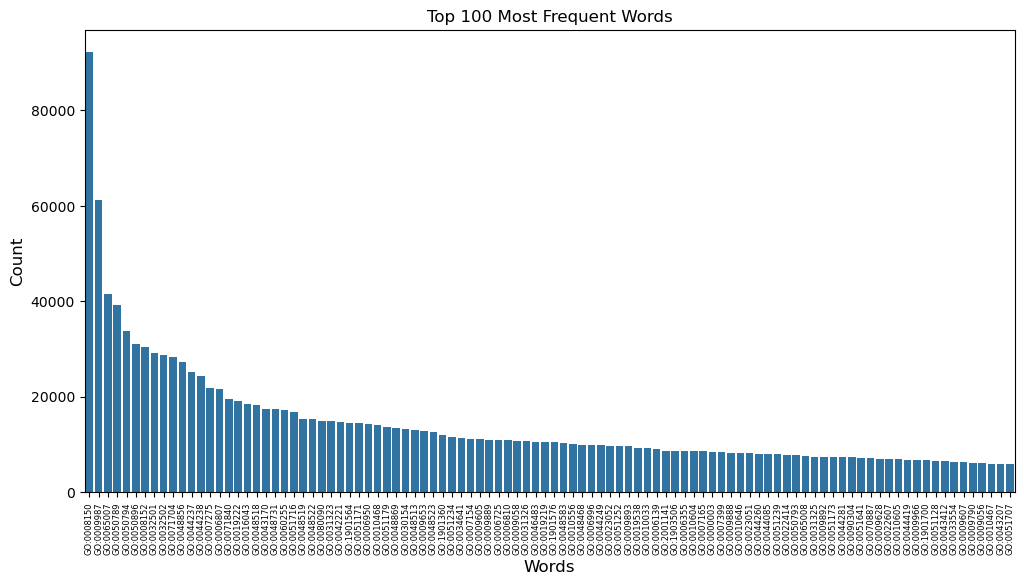

In [14]:
visualize_frequency(train_bpos)

Since a lot of labels seem to occur, let's take a look at the distribution of the values to see, which are the most common ones.

In [15]:
train_ccos = [go for cco in train_labels['CCO'].apply(ast.literal_eval) for go in cco]
len(train_ccos)

1196017

C:\Users\nikol\AppData\Local\Temp\ipykernel_27584\2212508678.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  bp.set_xticklabels(bp.get_xticklabels(), rotation=90, size=6)


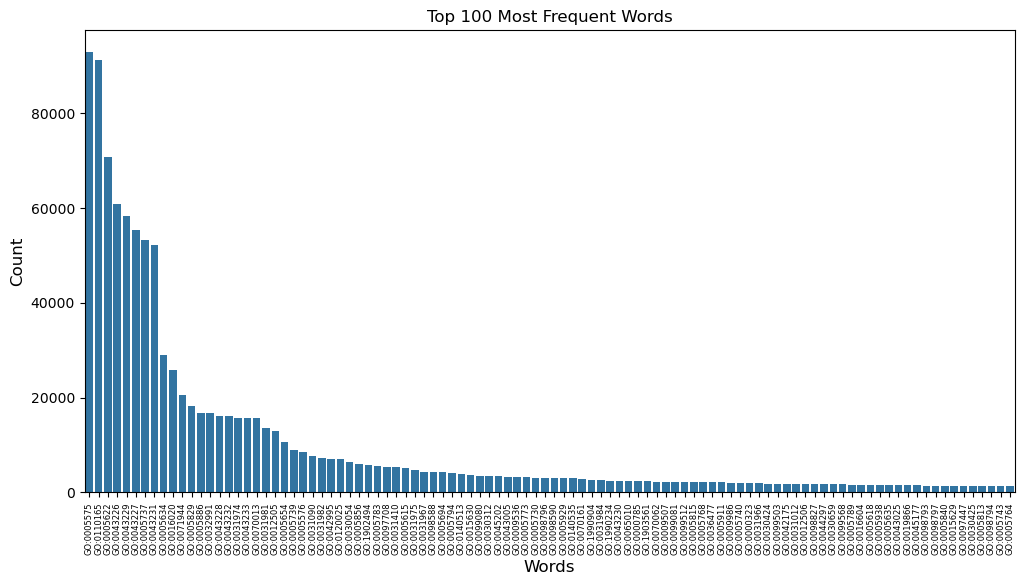

In [16]:
visualize_frequency(train_ccos)

In [17]:
train_mfos = [go for mfo in train_labels['MFO'].apply(ast.literal_eval) for go in mfo]
len(train_mfos)

670111

C:\Users\nikol\AppData\Local\Temp\ipykernel_27584\2212508678.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  bp.set_xticklabels(bp.get_xticklabels(), rotation=90, size=6)


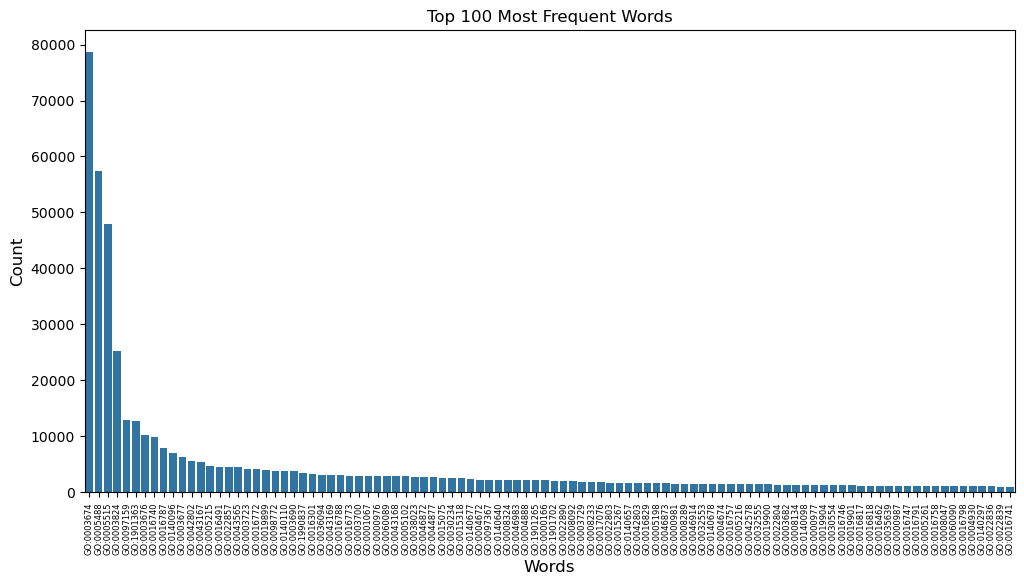

In [18]:
visualize_frequency(train_mfos)

In [19]:
print(f"Total GO terms: {len(train_bpos) + len(train_ccos) + len(train_mfos)}")

Total GO terms: 5363830


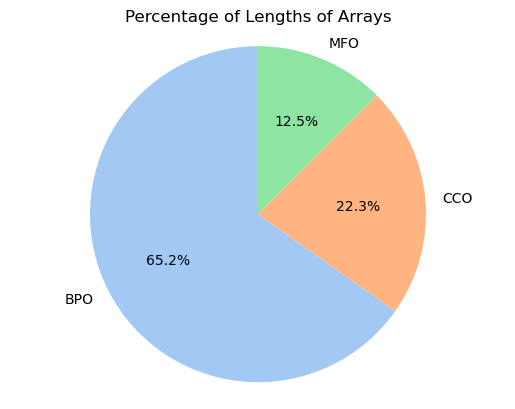

In [20]:
visualize_distribution(train_bpos, train_ccos, train_mfos)

Let's try putting them all together and taking only the first 1500 GOs that are most frequent.

In [21]:
terms_bpo = [f"BPO_{i}" for i in train_bpos]
terms_cco = [f"CCO_{i}" for i in train_ccos]
terms_mfo = [f"MFO_{i}" for i in train_mfos]

C:\Users\nikol\AppData\Local\Temp\ipykernel_27584\2212508678.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  bp.set_xticklabels(bp.get_xticklabels(), rotation=90, size=6)


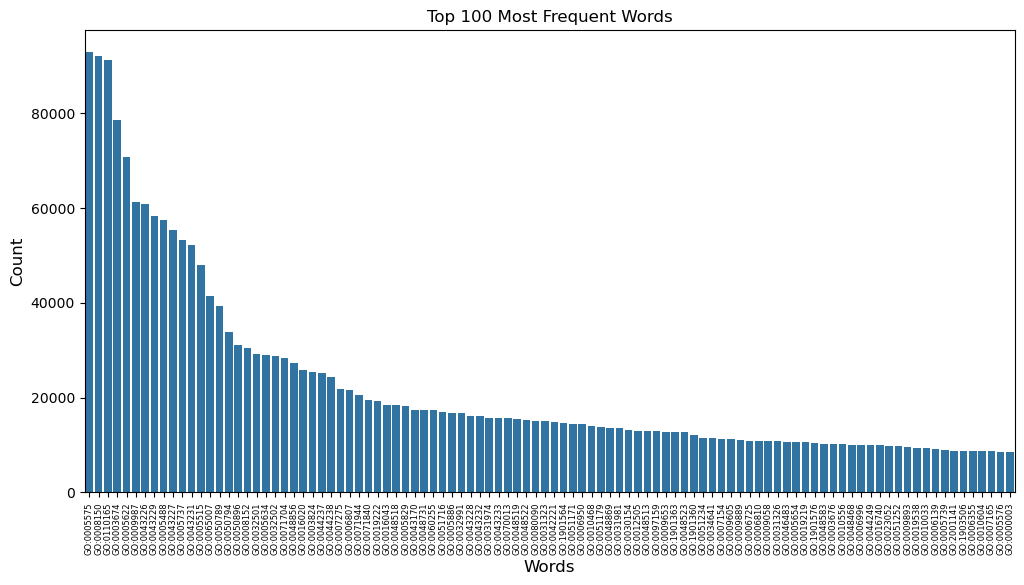

In [22]:
combined_freq = Counter(terms_bpo) + Counter(terms_cco) + Counter(terms_mfo)
visualize_frequency([*train_bpos, *train_ccos, *train_mfos])

In [23]:
most_common_1500 = combined_freq.most_common(1500)
most_common_terms = [term for term, freq in most_common_1500]

In [24]:
train_labels_all = []
train_labels_bpo = []
train_labels_cco = []
train_labels_mfo = []

for term in most_common_terms:
    type, go = term.split("_")
    train_labels_all.append(go)

    if type == "BPO":
        train_labels_bpo.append(go)
    elif type == "CCO":
        train_labels_cco.append(go)
    elif type == "MFO":
        train_labels_mfo.append(go)

In [25]:
len(train_labels_bpo), len(train_labels_cco), len(train_labels_mfo)

(1088, 220, 192)

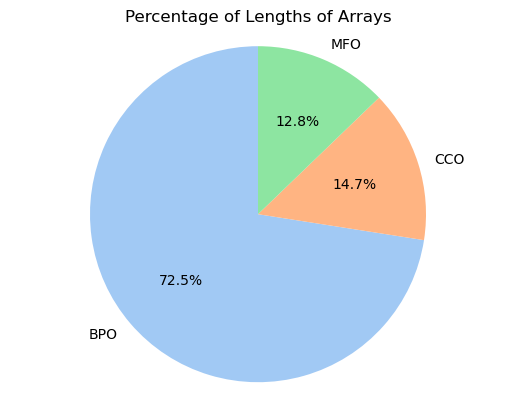

In [26]:
visualize_distribution(train_labels_bpo, train_labels_cco, train_labels_mfo)

## Training

### Preparing the Data

In [27]:
protein_ids = train_labels["ProteinID"]
df_1500 = pd.DataFrame(0, index=protein_ids, columns=train_labels_all)
df_1500.head()

,GO:0005575,GO:0008150,GO:0110165,GO:0003674,GO:0005622,GO:0009987,GO:0043226,GO:0043229,GO:0005488,GO:0043227,...,GO:0140053,GO:0034250,GO:0031345,GO:0098802,GO:0045861,GO:0001818,GO:0051783,GO:0031674,GO:0006874,GO:0051048
ProteinID,,,,,,,,,,,,,,,,,,,,,
O73864,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
O95231,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0A0B4J1F4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
P54366,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
P33681,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
def encode_labels_all(labels, labels_list):
    df_labels = pd.DataFrame(0, index=labels["ProteinID"], columns=labels_list)

    for idx, row in tqdm(labels.iterrows(), total=labels.shape[0], desc="Encoding labels"):
        for term in eval(row['BPO']) + eval(row['CCO']) + eval(row['MFO']):
            if term in labels_list:
                df_labels.at[row['ProteinID'], term] = 1

    return df_labels

In [29]:
def encode_labels_single(labels, labels_list, label):
    df_labels = pd.DataFrame(0, index=labels["ProteinID"], columns=labels_list)

    for idx, row in tqdm(labels.iterrows(), total=labels.shape[0], desc=f"Encoding {label} labels"):
        for term in eval(row[label]):
            if term in labels_list:
                df_labels.at[row['ProteinID'], term] = 1

    return df_labels

In [30]:
X = train_features.drop(columns=["ProteinID", "TaxonomyID"]).values
X

array([[ 0.04948843, -0.03293516,  0.03247323, ..., -0.04353154,
         0.0964628 ,  0.07306959],
       [-0.04461636,  0.06492499, -0.08026284, ...,  0.02672353,
         0.02787905, -0.04842958],
       [-0.02012804, -0.04977943,  0.00789446, ..., -0.03610279,
         0.00769301,  0.10623412],
       ...,
       [ 0.05602561,  0.03547018,  0.02198739, ...,  0.00337653,
        -0.02709501, -0.01591031],
       [ 0.01691809,  0.04133058,  0.00079253, ...,  0.0088079 ,
         0.00648063, -0.01334958],
       [ 0.06125151,  0.08340203,  0.0440247 , ...,  0.00138361,
        -0.04754627,  0.01012351]])

In [31]:
df_labels_all = encode_labels_all(train_labels, train_labels_all)
df_labels_all.head(5)

Encoding labels: 100%|███████████████████████████████████████████████████████| 142245/142245 [01:33<00:00, 1527.76it/s]


,GO:0005575,GO:0008150,GO:0110165,GO:0003674,GO:0005622,GO:0009987,GO:0043226,GO:0043229,GO:0005488,GO:0043227,...,GO:0140053,GO:0034250,GO:0031345,GO:0098802,GO:0045861,GO:0001818,GO:0051783,GO:0031674,GO:0006874,GO:0051048
ProteinID,,,,,,,,,,,,,,,,,,,,,
O73864,1,1,1,1,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
O95231,1,1,1,1,1,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
A0A0B4J1F4,1,1,1,1,0,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
P54366,1,0,1,1,1,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
P33681,1,1,1,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
df_labels_bpo = encode_labels_single(train_labels, train_labels_bpo, "BPO")
df_labels_bpo.head(5)

Encoding BPO labels: 100%|███████████████████████████████████████████████████| 142245/142245 [00:55<00:00, 2542.90it/s]


,GO:0008150,GO:0009987,GO:0065007,GO:0050789,GO:0050794,GO:0050896,GO:0008152,GO:0032501,GO:0032502,GO:0071704,...,GO:0023061,GO:0006665,GO:0140053,GO:0034250,GO:0031345,GO:0045861,GO:0001818,GO:0051783,GO:0006874,GO:0051048
ProteinID,,,,,,,,,,,,,,,,,,,,,
O73864,1,1,1,1,1,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
O95231,1,0,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0A0B4J1F4,1,1,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
P54366,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
P33681,1,0,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
df_labels_cco = encode_labels_single(train_labels, train_labels_cco, "CCO")
df_labels_cco.head()

Encoding CCO labels: 100%|███████████████████████████████████████████████████| 142245/142245 [00:20<00:00, 7026.04it/s]


,GO:0005575,GO:0110165,GO:0005622,GO:0043226,GO:0043229,GO:0043227,GO:0005737,GO:0043231,GO:0005634,GO:0016020,...,GO:0022625,GO:0031594,GO:0031976,GO:0008021,GO:0030430,GO:0098562,GO:0009534,GO:0000313,GO:0098802,GO:0031674
ProteinID,,,,,,,,,,,,,,,,,,,,,
O73864,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
O95231,1,1,1,1,1,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
A0A0B4J1F4,1,1,0,1,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
P54366,1,1,1,1,1,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
P33681,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [34]:
df_labels_mfo = encode_labels_single(train_labels, train_labels_mfo, "MFO")
df_labels_mfo.head()

Encoding MFO labels: 100%|██████████████████████████████████████████████████| 142245/142245 [00:12<00:00, 11070.98it/s]


,GO:0003674,GO:0005488,GO:0005515,GO:0003824,GO:0097159,GO:1901363,GO:0003676,GO:0016740,GO:0016787,GO:0140096,...,GO:0015085,GO:0031406,GO:0005085,GO:0004519,GO:0008234,GO:0016407,GO:0016830,GO:0004540,GO:0005096,GO:0016209
ProteinID,,,,,,,,,,,,,,,,,,,,,
O73864,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
O95231,1,1,1,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0A0B4J1F4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
P54366,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
P33681,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
df_labels_all.shape, df_labels_bpo.shape, df_labels_cco.shape, df_labels_mfo.shape

((142245, 1500), (142245, 1088), (142245, 220), (142245, 192))

In [36]:
y = df_labels_all.values
y

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0]], dtype=int64)

In [37]:
y_bpo = df_labels_bpo.values
y_bpo

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [38]:
y_cco = df_labels_cco.values
y_cco

array([[1, 1, 0, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0]], dtype=int64)

In [39]:
y_mfo = df_labels_mfo.values
y_mfo

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0]], dtype=int64)

In [40]:
train_size = int(len(X) * 0.8)

X_train_default = X[:train_size]
X_test_default = X[train_size:]

y_train_all = y[:train_size]
y_test_all = y[train_size:]

y_train_bpo = y_bpo[:train_size]
y_test_bpo = y_bpo[train_size:]

y_train_cco = y_cco[:train_size]
y_test_cco = y_cco[train_size:]

y_train_mfo = y_mfo[:train_size]
y_test_mfo = y_mfo[train_size:]

### Single Aspect Model

In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [42]:
class SingleAspectModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SingleAspectModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        f_1 = self.relu(self.fc1(x))
        d_1 = self.dropout(f_1)
        f_2 = self.relu(self.fc2(d_1))
        d_2 = self.dropout(f_2)
        out = torch.sigmoid(self.fc3(d_2))

        return out

In [43]:
X_train = torch.tensor(X_train_default, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train_all, dtype=torch.float32).to(device)

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [44]:
X_test = torch.tensor(X_test_default, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test_all, dtype=torch.float32).to(device)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [45]:
def train_single_aspect_model():
  input_size = X_train.shape[1]
  hidden_size = 512
  output_size = y_train.shape[1]
  learning_rate = 0.001
  num_epochs = 20

  model = SingleAspectModel(input_size, hidden_size, output_size).to(device)
  criterion = nn.BCELoss()
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)

  train_losses = []
  test_losses = []
  train_accuracies = []
  test_accuracies = []

  for epoch in range(num_epochs):
      model.train()
      running_loss = 0.0
      correct_train = 0
      total_train = 0

      for inputs, labels in train_loader:
          optimizer.zero_grad()
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          running_loss += loss.item()

          predicted = (outputs > 0.5).float()
          total_train += labels.size(0)
          correct_train += (predicted == labels).sum().item()

      train_loss = running_loss / len(train_loader)
      train_accuracy = 100 * correct_train / (total_train * output_size)
      train_losses.append(train_loss)
      train_accuracies.append(train_accuracy)

      model.eval()
      running_loss = 0.0
      correct_test = 0
      total_test = 0

      with torch.no_grad():
          for inputs, labels in test_loader:
              inputs, labels = inputs.to(device), labels.to(device)
              outputs = model(inputs)
              loss = criterion(outputs, labels)
              running_loss += loss.item()

              predicted = (outputs > 0.5).float()
              total_test += labels.size(0)
              correct_test += (predicted == labels).sum().item()

      test_loss = running_loss / len(test_loader)
      test_accuracy = 100 * correct_test / (total_test * output_size)
      test_losses.append(test_loss)
      test_accuracies.append(test_accuracy)

      print(f'Epoch [{epoch + 1}/{num_epochs}]:\n \
        Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%\n \
        Testing Loss: {test_loss:.4f}, Testing Accuracy: {test_accuracy:.2f}%')

  return model, train_losses, train_accuracies, test_losses, test_accuracies

In [46]:
single_model, single_train_losses, single_train_accuracies, single_test_losses, single_test_accuracies = train_single_aspect_model()

Epoch [1/20]:
         Training Loss: 0.0858, Training Accuracy: 97.83%
         Testing Loss: 0.0629, Testing Accuracy: 98.48%
Epoch [2/20]:
         Training Loss: 0.0826, Training Accuracy: 97.87%
         Testing Loss: 0.0630, Testing Accuracy: 98.48%
Epoch [3/20]:
         Training Loss: 0.0825, Training Accuracy: 97.87%
         Testing Loss: 0.0621, Testing Accuracy: 98.49%
Epoch [4/20]:
         Training Loss: 0.0824, Training Accuracy: 97.87%
         Testing Loss: 0.0620, Testing Accuracy: 98.49%
Epoch [5/20]:
         Training Loss: 0.0824, Training Accuracy: 97.87%
         Testing Loss: 0.0624, Testing Accuracy: 98.49%
Epoch [6/20]:
         Training Loss: 0.0823, Training Accuracy: 97.87%
         Testing Loss: 0.0628, Testing Accuracy: 98.49%
Epoch [7/20]:
         Training Loss: 0.0823, Training Accuracy: 97.87%
         Testing Loss: 0.0622, Testing Accuracy: 98.49%
Epoch [8/20]:
         Training Loss: 0.0823, Training Accuracy: 97.87%
         Testing Loss: 0.0621, T

### Multiple Aspects Model

In [47]:
class MultipleAspectsModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size_bpo, output_size_cco, output_size_mfo):
        super(MultipleAspectsModel, self).__init__()
        self.bpo = SingleAspectModel(input_size, hidden_size, output_size_bpo)
        self.cco = SingleAspectModel(input_size, hidden_size, output_size_cco)
        self.mfo = SingleAspectModel(input_size, hidden_size, output_size_mfo)

    def forward(self, x):
        out_bpo = self.bpo(x)
        out_cco = self.cco(x)
        out_mfo = self.mfo(x)

        return out_bpo, out_cco, out_mfo

In [48]:
y_train_bpos = torch.tensor(y_train_bpo, dtype=torch.float32).to(device)
y_train_ccos = torch.tensor(y_train_cco, dtype=torch.float32).to(device)
y_train_mfos = torch.tensor(y_train_mfo, dtype=torch.float32).to(device)

train_dataset = TensorDataset(X_train, y_train_bpos, y_train_ccos, y_train_mfos)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [49]:
y_test_bpos = torch.tensor(y_test_bpo, dtype=torch.float32).to(device)
y_test_ccos = torch.tensor(y_test_cco, dtype=torch.float32).to(device)
y_test_mfos = torch.tensor(y_test_mfo, dtype=torch.float32).to(device)

test_dataset = TensorDataset(X_test, y_test_bpos, y_test_ccos, y_test_mfos)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [52]:
def train_multiple_aspect_model():
  input_size = X_train.shape[1]
  hidden_size = 512
  output_size = {'bpo': y_train_bpo.shape[1], 'cco': y_train_cco.shape[1], 'mfo':y_train_mfo.shape[1]}
  learning_rate = 0.001
  num_epochs = 20

  model = MultipleAspectsModel(input_size, hidden_size, output_size['bpo'], output_size['cco'], output_size['mfo']).to(device)
  criterion = nn.BCELoss()
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)

  train_losses = {'bpo': [], 'cco': [], 'mfo': [], 'total': []}
  test_losses = {'bpo': [], 'cco': [], 'mfo': [], 'total': []}
  train_accuracies = {'bpo': [], 'cco': [], 'mfo': [], 'total': []}
  test_accuracies = {'bpo': [], 'cco': [], 'mfo': [], 'total': []}

  for epoch in range(num_epochs):
      model.train()
      running_loss = {'bpo': 0.0, 'cco': 0.0, 'mfo': 0.0, 'total': 0.0}
      correct_train = {'bpo': 0, 'cco': 0, 'mfo': 0, 'total': 0}
      total_train = 0

      for inputs, labels_bpo, labels_cco, labels_mfo in train_loader:
          optimizer.zero_grad()
          outputs_bpo, outputs_cco, outputs_mfo = model(inputs)

          loss_bpo = criterion(outputs_bpo, labels_bpo)
          loss_cco = criterion(outputs_cco, labels_cco)
          loss_mfo = criterion(outputs_mfo, labels_mfo)

          total_loss = (loss_bpo + loss_cco + loss_mfo) / 3
          total_loss.backward()
          optimizer.step()

          running_loss['bpo'] += loss_bpo.item()
          running_loss['cco'] += loss_cco.item()
          running_loss['mfo'] += loss_mfo.item()
          running_loss['total'] += total_loss.item()

          predicted_bpo = (outputs_bpo > 0.5).float()
          predicted_cco = (outputs_cco > 0.5).float()
          predicted_mfo = (outputs_mfo > 0.5).float()

          total_train += labels_bpo.size(0)
          correct_train['bpo'] += (predicted_bpo == labels_bpo).sum().item()
          correct_train['cco'] += (predicted_cco == labels_cco).sum().item()
          correct_train['mfo'] += (predicted_mfo == labels_mfo).sum().item()

      for aspect in ['bpo', 'cco', 'mfo']:
        train_losses[aspect].append(running_loss[aspect] / len(train_loader))
        train_accuracies[aspect].append(100 * correct_train[aspect] / (total_train * output_size[aspect]))

      train_losses['total'].append(running_loss['total'] / len(train_loader))
      train_accuracies['total'].append((train_accuracies['bpo'][-1] + train_accuracies['cco'][-1] + train_accuracies['mfo'][-1]) / 3)

      model.eval()
      running_loss = {'bpo': 0.0, 'cco': 0.0, 'mfo': 0.0, 'total': 0.0}
      correct_test = {'bpo': 0, 'cco': 0, 'mfo': 0, 'total': 0}
      total_test = 0

      with torch.no_grad():
          for inputs, labels_bpo, labels_cco, labels_mfo in test_loader:
              outputs_bpo, outputs_cco, outputs_mfo = model(inputs)

              loss_bpo = criterion(outputs_bpo, labels_bpo)
              loss_cco = criterion(outputs_cco, labels_cco)
              loss_mfo = criterion(outputs_mfo, labels_mfo)
              total_loss = (loss_bpo + loss_cco + loss_mfo) / 3
              
              running_loss['bpo'] += loss_bpo.item()
              running_loss['cco'] += loss_cco.item()
              running_loss['mfo'] += loss_mfo.item()
              running_loss['total'] += total_loss.item()

              predicted_bpo = (outputs_bpo > 0.5).float()
              predicted_cco = (outputs_cco > 0.5).float()
              predicted_mfo = (outputs_mfo > 0.5).float()

              total_test += labels_bpo.size(0)
              correct_test['bpo'] += (predicted_bpo == labels_bpo).sum().item()
              correct_test['cco'] += (predicted_cco == labels_cco).sum().item()
              correct_test['mfo'] += (predicted_mfo == labels_mfo).sum().item()


      for aspect in ['bpo', 'cco', 'mfo']:
        test_losses[aspect].append(running_loss[aspect] / len(test_loader))
        test_accuracies[aspect].append(100 * correct_test[aspect] / (total_test * output_size[aspect]))

      test_losses['total'].append(running_loss['total'] / len(test_loader))
      test_accuracies['total'].append((test_accuracies['bpo'][-1] + test_accuracies['cco'][-1] + test_accuracies['mfo'][-1]) / 3)

      print(f'Epoch [{epoch + 1}/{num_epochs}]:\n \
        Training Loss:\n \
          BPO: {train_losses["bpo"][-1]:.4f}, CCO: {train_losses["cco"][-1]:.4f}, MFO: {train_losses["mfo"][-1]:.4f}, Total: {train_losses["total"][-1]:.4f}\n \
        Training Accuracy:\n \
          BPO: {train_accuracies["bpo"][-1]:.2f}%, CCO: {train_accuracies["cco"][-1]:.2f}%, MFO: {train_accuracies["mfo"][-1]:.2f}%, Total: {train_accuracies["total"][-1]:.2f}%\n \
        Testing Loss:\n \
          BPO: {test_losses["bpo"][-1]:.4f}, CCO: {test_losses["cco"][-1]:.4f}, MFO: {test_losses["mfo"][-1]:.4f}, Total: {test_losses["total"][-1]:.4f}\n \
        Testing Accuracy:\n \
          BPO: {test_accuracies["bpo"][-1]:.2f}%, CCO: {test_accuracies["cco"][-1]:.2f}%, MFO: {test_accuracies["mfo"][-1]:.2f}%, Total: {test_accuracies["total"][-1]:.2f}%')

  return model, train_losses, train_accuracies, test_losses, test_accuracies

In [53]:
multiple_model, multiple_train_losses, multiple_train_accuracies, multiple_test_losses, multiple_test_accuracies = train_multiple_aspect_model()

Epoch [1/20]:
         Training Loss:
           BPO: 0.0823, CCO: 0.1081, MFO: 0.0818, Total: 0.0907
         Training Accuracy:
           BPO: 98.07%, CCO: 96.57%, MFO: 97.89%, Total: 97.51%
         Testing Loss:
           BPO: 0.0608, CCO: 0.0838, MFO: 0.0474, Total: 0.0640
         Testing Accuracy:
           BPO: 98.67%, CCO: 97.28%, MFO: 98.81%, Total: 98.25%
Epoch [2/20]:
         Training Loss:
           BPO: 0.0789, CCO: 0.1049, MFO: 0.0783, Total: 0.0874
         Training Accuracy:
           BPO: 98.11%, CCO: 96.61%, MFO: 97.94%, Total: 97.55%
         Testing Loss:
           BPO: 0.0621, CCO: 0.0841, MFO: 0.0496, Total: 0.0652
         Testing Accuracy:
           BPO: 98.67%, CCO: 97.31%, MFO: 98.81%, Total: 98.26%
Epoch [3/20]:
         Training Loss:
           BPO: 0.0788, CCO: 0.1048, MFO: 0.0782, Total: 0.0873
         Training Accuracy:
           BPO: 98.11%, CCO: 96.61%, MFO: 97.94%, Total: 97.56%
         Testing Loss:
           BPO: 0.0605, CCO: 0.0838, MF

## Store

In [63]:
torch.save(single_model.state_dict(), "./models/single_aspect_model.bin")

In [64]:
torch.save(multiple_model.state_dict(), "./models/multiple_aspects_model.bin")

In [65]:
single_config = {
    "input_size": X_train.shape[1],
    "hidden_size": 512,
    "output_size": y_train.shape[1],
}
with open("./models/single_aspect_config.json", "w") as f:
    json.dump(single_config, f)

In [66]:
multiple_config = {
    "input_size": X_train.shape[1],
    "hidden_size": 512,
    "output_size_bpo": y_train_bpo.shape[1],
    "output_size_cco": y_train_cco.shape[1],
    "output_site_mfo": y_train_mfo.shape[1]
}
with open("./models/multiple_aspects_config.json", "w") as f:
    json.dump(multiple_config, f)